In [152]:
import pandas as pd
import chess
import random
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split


 # Import data

 Sample the data as there is too large of a dataset

In [153]:
df = pd.read_csv("archive/chessData.csv")

n = 500000
df = df.sample(n=n, replace=False, random_state=7).reset_index(drop=True)

df.head()


,FEN,Evaluation
0,8/5n2/p4rkp/PppP1R2/2b3P1/2P1K3/8/6R1 w - - 5 41,-280
1,8/8/1P6/3K4/P7/4k3/8/2r5 b - - 3 47,0
2,1r2n1k1/rb2q3/pN2p1pp/Pp1pPp2/3P1P2/1Q3BP1/1PR...,+276
3,2r2rk1/1p3pn1/p2p1nP1/2pPp3/P1P1P3/2N5/1P5P/R1...,-46
4,r2q1rk1/pp1n2pp/3pb3/2p1p3/5PP1/2NP3P/PPP5/R1B...,+105


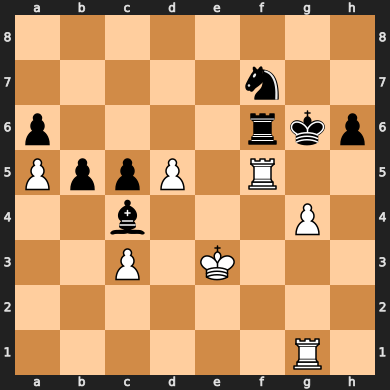

In [154]:
board = chess.Board(df["FEN"][0])
board

In [155]:
df.shape

(500000, 2)

 # Evalutation

 Convert the string evaluations into a number. There some issues with the conversion to string and as such they will be removed.

In [156]:
def eval_convert(fen, x):
    if("#" in x):  x = 10000 if("+" in x) else -10000 

    try: 
        evaluation = int(x)/10
        return evaluation if("w" in fen) else -evaluation
    
    except: return None


In [157]:
df["Evaluation"] = df.apply(lambda x: eval_convert(x["FEN"], x["Evaluation"]), axis=1)
df = df.dropna()

df.head()


,FEN,Evaluation
0,8/5n2/p4rkp/PppP1R2/2b3P1/2P1K3/8/6R1 w - - 5 41,-28.0
1,8/8/1P6/3K4/P7/4k3/8/2r5 b - - 3 47,-0.0
2,1r2n1k1/rb2q3/pN2p1pp/Pp1pPp2/3P1P2/1Q3BP1/1PR...,-27.6
3,2r2rk1/1p3pn1/p2p1nP1/2pPp3/P1P1P3/2N5/1P5P/R1...,-4.6
4,r2q1rk1/pp1n2pp/3pb3/2p1p3/5PP1/2NP3P/PPP5/R1B...,10.5


In [158]:
def board_state(board):
    if(type(board) == str): board = chess.Board(board)
    turn = board.turn
    
    # White
    wksc = 1 if(board.has_kingside_castling_rights(chess.WHITE)) else 0
    wqsc = 1 if(board.has_queenside_castling_rights(chess.WHITE)) else 0
    wch = 1 if(board.is_check()) else 0 
    #wep = 1 if(board.has_legal_en_passant()) else 0

    # Black
    bksc = 1 if(board.has_kingside_castling_rights(chess.BLACK)) else 0
    bqsc = 1 if(board.has_queenside_castling_rights(chess.BLACK)) else 0
    #bep = 1 if(board.has_legal_en_passant()) else 0
    bch = 1 if(board.was_into_check()) else 0
    
    white_state = (wksc,wqsc,wch) # ((wksc,wqsc,wep, wch)
    
    black_state = (bksc,bqsc,bch) #(bksc,bqsc,bep,bch))
    
    if(turn == chess.BLACK):
        temp = white_state
        white_state = black_state 
        black_state = temp
       
    
    return list(white_state) + list(black_state)

board_state(board)


[0, 0, 0, 0, 0, 0]

In [159]:
def possible_moves(board):
    moves = [move for move in board.legal_moves]
    
    def board_order(move):
        check = 1 if(board.gives_check(move)) else 0
        capture = 1 if(board.is_capture(move)) else 0
        return (check, capture)
    
    return sorted(moves, key=board_order, reverse=True)
    
ordered_moves = possible_moves(board)

ordered_moves


[Move.from_uci('f5f6'),
 Move.from_uci('f5g5'),
 Move.from_uci('f5h5'),
 Move.from_uci('f5e5'),
 Move.from_uci('f5f4'),
 Move.from_uci('f5f3'),
 Move.from_uci('f5f2'),
 Move.from_uci('f5f1'),
 Move.from_uci('e3f4'),
 Move.from_uci('e3e4'),
 Move.from_uci('e3f3'),
 Move.from_uci('e3f2'),
 Move.from_uci('e3d2'),
 Move.from_uci('g1g3'),
 Move.from_uci('g1g2'),
 Move.from_uci('g1h1'),
 Move.from_uci('g1f1'),
 Move.from_uci('g1e1'),
 Move.from_uci('g1d1'),
 Move.from_uci('g1c1'),
 Move.from_uci('g1b1'),
 Move.from_uci('g1a1'),
 Move.from_uci('d5d6'),
 Move.from_uci('g4g5')]

In [160]:
ordered_moves = [board.san(move) for move in ordered_moves]

ordered_moves


['Rxf6+',
 'Rg5+',
 'Rh5',
 'Re5',
 'Rf4',
 'Rf3',
 'Rf2',
 'Rff1',
 'Kf4',
 'Ke4',
 'Kf3',
 'Kf2',
 'Kd2',
 'Rg3',
 'Rg2',
 'Rh1',
 'Rgf1',
 'Re1',
 'Rd1',
 'Rc1',
 'Rb1',
 'Ra1',
 'd6',
 'g5']

 ## Vectorising board

 Always have the player to be on top.

In [161]:
def convert_to_int(board):
    if(type(board) == str): board = chess.Board(board)
    
    if(board.turn == chess.WHITE):
        relative_white = chess.WHITE
        relative_black = chess.BLACK
        
        increment = 1
        start = 0
        end = 8
    
    else:
        relative_white = chess.BLACK
        relative_black = chess.WHITE
        
        increment = -1
        start = 7
        end = -1
        
    l = [[0 for _ in range(12)] for _ in range(64)]
    
    for sq in chess.scan_reversed(board.occupied_co[relative_white]):  # Check if white
        l[sq][board.piece_type_at(sq)-1] = 1 
    for sq in chess.scan_reversed(board.occupied_co[relative_black]):  # Check if black
        l[sq][-board.piece_type_at(sq)] = 1
    
    
    vector = [[v for v in l[i*8: 8*(i+1)]] for i in range(start, end, increment)]
    #vector = vector.flatten()
    return vector


#np.asarray(convert_to_int(board.mirror())).shape
convert_to_int(board)

[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
 [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
 [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
 [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

 # Inputs

 All inputs should be in a list format

In [162]:
boards = list(df["FEN"].apply(convert_to_int))
evaluations = np.array(list(df["Evaluation"]))
states = list(df["FEN"].apply(board_state))

In [163]:
X = list(zip(boards, states))
y = evaluations
#y = norm_evals = (evaluations-np.min(evaluations))/(np.max(evaluations)-np.min(evaluations))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
boards_train, states_train = list(zip(*X_train))
boards_test, states_test = list(zip(*X_test))

#print("Train size: ", np.asarray(X_train).shape)
#print("Test size: ", np.asarray(X_test).shape)


In [164]:
boards_train, boards_test = np.array(boards_train), np.array(boards_train)
states_train, states_test = np.array(states_train), np.array(states_test)

In [165]:
import keras
from keras import layers

def build_model(num_layers=3):
    input1 = tf.keras.layers.Input(shape=(8,8,12))
    conv1 = tf.keras.layers.Conv2D(kernel_size=(8,8), padding="same", activation="relu", filters=64, input_shape=(8,8,12))(input1)
    bn1 = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=1e-05)(conv1)
    conv2 = tf.keras.layers.Conv2D(kernel_size=(8,8), padding="same", activation="relu", filters=64, input_shape=(8,8,1))(bn1)
    bn2 = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=1e-05)(conv2)
    flatten1 = tf.keras.layers.Flatten()(bn2)
    input2 = tf.keras.layers.Input(shape=(6,))

    conc = tf.keras.layers.concatenate([flatten1,input2])

    Denselayer1 = tf.keras.layers.Dense(1024, activation='relu')(conc)
    Denselayer2 = tf.keras.layers.Dense(512, activation='relu')(Denselayer1)
    Denselayer3 = tf.keras.layers.Dense(256, activation='relu')(Denselayer2)
    Denselayer4 = tf.keras.layers.Dense(256, activation='relu')(Denselayer3)
    Output = tf.keras.layers.Dense(1, activation='linear')(Denselayer4)
    
    return tf.keras.models.Model(inputs=[input1, input2], outputs=Output)

model = build_model()
model.summary()


c:\Users\canajosd\AppData\Local\miniconda3\envs\chess\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "functional_171"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, 8, 8, 12)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_70 (Conv2D)  │ (None, 8, 8, 64)  │     49,216 │ input_layer_14[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 64)  │        256 │ conv2d_70[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_71 (Conv2D)  │ (None, 8, 8, 64)  │    262,208 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 64)  │        256 │ conv2d_71[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_12          │ (None, 4096)      │          0 │ batch_normalizat… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_15      │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 4102)      │          0 │ flatten_12[0][0], │
│ (Concatenate)       │                   │            │ input_layer_15[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_60 (Dense)    │ (None, 1024)      │  4,201,472 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_61 (Dense)    │ (None, 512)       │    524,800 │ dense_60[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_62 (Dense)    │ (None, 256)       │    131,328 │ dense_61[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_63 (Dense)    │ (None, 256)       │     65,792 │ dense_62[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_64 (Dense)    │ (None, 1)         │        257 │ dense_63[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,235,585 (19.97 MB)

 Trainable params: 5,235,329 (19.97 MB)

 Non-trainable params: 256 (1.00 KB)

In [166]:
model.compile(
    optimizer="adam",
    loss="mse",
    metrics=['accuracy',tf.keras.metrics.MeanAbsoluteError()],
)

# keras.losses.MeanSquaredError()

In [167]:
model.fit(x=[boards_train, states_train],y=y_train,
    batch_size=32,
    epochs=100,
    validation_split=0.1,
    verbose=2
)

Epoch 1/100
11250/11250 - 676s - 60ms/step - accuracy: 0.0421 - loss: 15902.8496 - mean_absolute_error: 45.0243 - val_accuracy: 0.0326 - val_loss: 14729.7090 - val_mean_absolute_error: 44.2932
Epoch 2/100
11250/11250 - 668s - 59ms/step - accuracy: 0.0438 - loss: 13385.6729 - mean_absolute_error: 41.9001 - val_accuracy: 0.0396 - val_loss: 13896.8691 - val_mean_absolute_error: 41.2602
Epoch 3/100
11250/11250 - 691s - 61ms/step - accuracy: 0.0444 - loss: 11595.2715 - mean_absolute_error: 39.3665 - val_accuracy: 0.0510 - val_loss: 14400.7393 - val_mean_absolute_error: 42.0149
Epoch 4/100
11250/11250 - 653s - 58ms/step - accuracy: 0.0431 - loss: 9898.6484 - mean_absolute_error: 36.6091 - val_accuracy: 0.0593 - val_loss: 14509.1924 - val_mean_absolute_error: 42.1670
Epoch 5/100
11250/11250 - 658s - 58ms/step - accuracy: 0.0433 - loss: 8243.5771 - mean_absolute_error: 33.8038 - val_accuracy: 0.0476 - val_loss: 14622.8604 - val_mean_absolute_error: 41.0633
Epoch 6/100
11250/11250 - 659s - 59ms

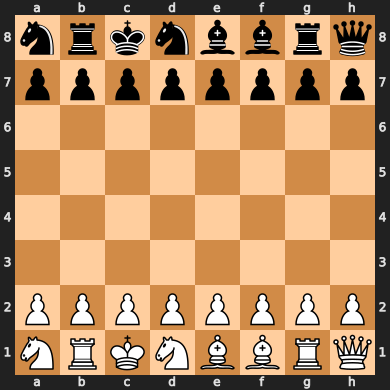

In [168]:
board = chess.Board.from_chess960_pos(random.randint(0, 959))

board

In [169]:
input_board = convert_to_int(board)

test_eval = model.predict(np.array([input_board]), verbose=0)[0]


print(test_eval)

ValueError: Layer 'functional_171' expected 2 input(s). Received 1 instead.

In [170]:
model.save("model1.keras")